In [52]:
# default_exp feature_eng

In [53]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [61]:
# export
from mlfinlab.microstructural_features import (
    get_roll_measure,
    get_roll_impact,
    get_bar_based_kyle_lambda,
    get_bar_based_amihud_lambda,
)
from mlfinlab.microstructural_features.entropy import (
    get_shannon_entropy,
    get_lempel_ziv_entropy,
    get_plug_in_entropy,
    get_konto_entropy
)
from mlfinlab.structural_breaks import get_sadf


from copy import deepcopy
import pandas as pd
import numpy as np
import logging
import string
from mlbt.load_data import load_feat, save_feat
from mlbt.frac_diff import frac_diff_ffd
from mlbt.load_data import get_data, SYMBOLS_CSV, safe_feat_name, process_bars
SYMBOLS_CSV = SYMBOLS_CSV.copy()
SYMBOLS_CSV.columns = SYMBOLS_CSV.columns.str.lower()
SYMBOLS_DICT = SYMBOLS_CSV.T.to_dict()


def roll_measure(df, window, price="Close"):
    """The Roll measure attempts to estimate the bid-ask spread (i.e. liquidity) of an instrument"""
    return get_roll_measure(df[price], window)


def roll_impact(df, window, price="Close", dollar_volume="Dollar Volume"):
    """The Roll measure divided by dollar volume"""
    return roll_measure(df, window, price) / df[dollar_volume] * 1e9


def kyle(df, window, price="Close", volume="Volume"):
    """A measure of market impact cost (i.e. liquidity) from Kyle (1985)"""
    return get_bar_based_kyle_lambda(df[price], df[volume], window) * 1e9


def amihud(df, window, price="Close", dollar_volume="Dollar Volume"):
    """A measure of market impact cost (i.e. liquidity) from Amihud (2002)"""
    return get_bar_based_amihud_lambda(df[price], df[dollar_volume], window) * 1e9


def autocorr(df, window, lag, column="Close"):
    """The raw price series' serial correlation"""
    return df[column].rolling(window).apply(lambda x: x.autocorr(lag=lag), raw=False)


def corr(df, window, other, column="Close"):
    """The raw price series' serial correlation"""
    return df[column].rolling(window).corr(other)


def rolling_stdev(df, window, column="Close"):
    """The raw price series' standard deviation"""
    return df[column].rolling(window).std()


def ewm_stdev(df, com, column="Close"):
    """The raw price series' standard deviation"""
    return df[column].ewm(com=com).std()


def ewm_mean(df, com, column="Close"):
    """The raw price series' standard deviation"""
    return df[column].ewm(com=com).mean()


def int_ret(df, periods=1, column="Close"):
    """First difference of log-transformed prices"""
    return df[column].pct_change(periods=periods)


def log_ret(df, periods=1, column="Close"):
    """First difference of log-transformed prices"""
    return np.log(df[column]).diff(periods=periods)


def ffd(df, d, column="Close"):
    """Fractionally differentiated prices"""
    return frac_diff_ffd(np.log(df[column].to_frame('Close')), d)['Close']


def volratio(df, volume="Volume", buy_volume="Buy Volume"):
    """
    EWM of bar-by-bar buy volume divided by total volume
    (i.e. a value >0.50 would indicate buyers driving the market)
    """
    return df[buy_volume] / df[volume]


def binary_encoding(returns):
    return np.sign(returns).map({-1: 'a', 1: 'b'})


def quantile_encoding(returns, q=10):
    return pd.qcut(returns, q=q, labels=list(string.printable[:q]), duplicates='drop')


def sigma_encoding(returns):
    stdev = returns.std()

    nbins = int((returns.max() - returns.min()) / stdev)
    min_ = returns.min()

    bins = pd.IntervalIndex.from_tuples([
        (
            min_+ (stdev * i), min_+ (stdev * (i + 1))
        ) for i in range(nbins + 1)
    ])
    x = pd.cut(returns, bins)

    mapper = dict(zip(bins, list(string.printable)[:nbins]))
    sigma_q = x.values.map(mapper)
    return pd.Series(sigma_q, index=returns.index)    

ENCODERS = {
    'binary': binary_encoding,
    'quantile': quantile_encoding,
    'sigma': sigma_encoding,
}


ENTROPY_FUNS = {
    'shannon': get_shannon_entropy,
    'plugin': get_plug_in_entropy,
    'konto': get_konto_entropy,
    'lz': get_lempel_ziv_entropy,
}

def entropy(df, method, encoding, window, column="Close", konto_len=None):
    encoder = ENCODERS[encoding]
    entropy_fun = ENTROPY_FUNS[method]
    kwargs = {"window": konto_len} if konto_len is not None else {}
#     apply_entropy = lambda x, fun:
    debug = lambda x: x
    encoded = encoder(df[column]).dropna()
    rolling = encoded.rolling(window)


#     df = pd.DataFrame({'col1':list('some_string')})
#     window = 5
    ss = pd.Series([
        ''.join(encoded.values[max(i-window+1, 0): i+1])
        for i in range(len(encoded.values))
    ])
    
    entropies = ss.apply(lambda x: entropy_fun(x, **kwargs))
    entropies.index = encoded.index

    entropies[:window-1]=np.nan
    assert entropies.index.is_unique
    return entropies


def close(df, column="Close"):
    return df[column]


def lag(df, lag, column="Close"):
    return df[column].shift(lag)


def lag_change(df, lag, column="Close"):
    return df[column].pct_change(lag)


def lag_diff(df, lag, column="Close"):
    col = df[column]
    return col - col.shift(lag)


def ema(df, com, column="Close"):
    return df[column].ewm(com=com).mean()


def sadf(df, model="linear", min_length=20, lags=5, bars=10000000000000, column="Close"):
    return get_sadf(df[column].iloc[-bars:], model=model, add_const=True, min_length=min_length, lags=lags, num_threads=1)

    
# Dates
def month(df, column="Time"):
    return df[column].dt.month


def week(df, column="Time"):
    return df[column].dt.week

    
def day(df, column="Time"):
    return df[column].dt.day

    
def weekday(df, column="Time"):
    return df[column].dt.weekday

    
def hour(df, column="Time"):
    return df[column].dt.hour


def tick_bars(df, size, column="Close"):
    return process_bars(df, size, "tick")[column]


def make_bars(df, type_, size, column="Close"):
    return process_bars(df, size, type_)[column]

    
FEATURES = {
    "auto": autocorr,
    "corr": corr,
    "rolling_stdev": rolling_stdev,
    "ewm_stdev": ewm_stdev,
    "ewm_mean": ewm_mean,
    "roll": roll_measure,
    "rollimp": roll_impact,
    "kyle": kyle,
    "amihud": amihud,
    "volratio": volratio,
    "entropy": entropy,
    "int_ret": int_ret,
    "log_ret": log_ret,
    "ffd": ffd,
    "close": close,
    "lag": lag,
    "lag_change": lag_change,
    "ema": ema,
    
    "sadf": sadf,

    "time_bars": tick_bars,
    "make_bars": make_bars,

    "weekday": weekday,
    "hour": hour,
}

def run_feature_engineering(config, deck):
    """Load already-engineered features or engineer if we can't"""
    for symbol, symbol_deck in deck.items():
        logging.debug(f"{symbol}: Feature engineering for {len(config['features'])} features")
        bars = symbol_deck['bars']
        feats = []
        for feat_config in config["features"]:
            # We pass a copy in so the feat_eng code can modify that to its hearts content,
            # while for us the information remains non-redundant
            name = safe_feat_name(feat_config, safe_for_fs=False)
            feat = engineer_feature(deck, symbol, config, feat_config)["Close"]
            logging.debug(f'Got {feat.shape} shape for feature: {name}')
            feat.name = name
            bars_index = deck[symbol]['bars'].index
            if feat.index.shape != bars_index.shape:
                # We're only interested in values we have prices for
                # Do this now so concat below is fast (and has the same set of indices across)
                feat = feat.reindex(index=bars_index, method='ffill')
            
            feats.append(feat)
        feats2 = pd.concat(feats, axis=1)
        logging.debug(f"Joined {len(feats)} features into {feats2.shape} shape")
        # Reindex in case of outside feats
        deck[symbol]['feats'] = feats2
    return deck

def get_bars(deck, symbol, config, feat_conf):
    # We can either compute something on already sampled bars,
    # but if we're making bars we'd likely want raw data
    if symbol in deck and not feat_conf['name'] == 'make_bars':
        # TODO: Remove deep copy
        bars = deck[symbol]['bars'].copy(deep=True)
    else:
        # We're loading a feature external to the price data of our trading universe
        bars = get_data(symbol, "minutely", config["start_date"], config["end_date"])
        
    return bars

def fill_out_symbol(feat_conf, for_symbol):
    symbol = feat_conf['symbol'] = feat_conf.get('symbol', for_symbol)
    if isinstance(symbol, dict):
        feat_conf['symbol'] = fill_out_symbol(symbol, for_symbol)
    return feat_conf
    

def engineer_feature(deck, for_symbol, config, feat_conf):
    """Parse and compute a feature"""
    feat_conf = deepcopy(feat_conf)
    fill_out_symbol(feat_conf, for_symbol)

    symbol = feat_conf['symbol']

    feat = load_feat(config, feat_conf)
    if feat is not None:
        return feat

    
    if isinstance(symbol, dict):
        # We're computing a feature on a feature
        df = engineer_feature(deck, for_symbol, config, symbol)
    else:
        df = get_bars(deck, symbol, config, feat_conf)
    
    feat = compute_feature(deck, for_symbol, config, feat_conf, symbol, df)

    if config["save_to_disk"]:
        save_feat(config, feat_conf, feat)
    return feat

def compute_feature(deck, for_symbol, config, feat_conf, symbol, df):
    logging.debug(f"Computing {feat_conf['name']} for {for_symbol}: {feat_conf}")
    drop = ['name', 'symbol']
    params = {k:v for k, v in feat_conf.items() if not k in drop}

    feat_name = feat_conf['name']
    if feat_name in ['sector', 'exchange']:
        categories = list(sorted(set(SYMBOLS_CSV[feat_name])))
        category = SYMBOLS_DICT[symbol][feat_name]
        feat = pd.Series(categories.index(category), index=df.index)
    else:
        feat = FEATURES[feat_name](df, **params)
            
    # Every feature's column is called Close to enable easy recursion
    feat = feat.to_frame("Close")
        
    return feat


def define_feature_configs():
    """Stake out the list of features that is the basis for our features matrix"""
    ffd_f = {"name": "ffd", "d": 0.3}
    log_ret = {"name": "log_ret"}
    vix_1h = {"name": "make_bars", "type_": "time", "size": 60, "symbol": 'VIX.XO'}
    int_ret_vix = {"name": "int_ret", "symbol": vix_1h}
    log_ret_vix = {"name": "log_ret", "symbol": vix_1h}

    es_1h = {"name": "make_bars", "type_": "time", "size": 60, "symbol": '@ES#C'}
    ty_1h = {"name": "make_bars", "type_": "time", "size": 60, "symbol": '@TY#C'}
    log_ret_es_1h = {"name": "log_ret", "symbol": es_1h}
    log_ret_ty_1h = {"name": "log_ret", "symbol": ty_1h}

    volratio = {"name": "volratio"}
    sadf = {"name": "sadf", "bars": 10000}
    
    features = [
        log_ret,
        ffd_f,
        es_1h,
        ty_1h,
#         sadf,
    ]
    windows = [25, 50, 250]#, 500]
    windows_ent = [250, 500]

    for window in windows:
        features.append({"name": "log_ret", "periods": window})
        
        roll = {"name": "roll", "window": window}
        features.append(roll)
        features.append({"name": "rolling_stdev", "window": window, "symbol": roll})

        rollimp = {"name": "rollimp", "window": window}
        features.append(rollimp)
        features.append({"name": "rolling_stdev", "window": window, "symbol": rollimp})

        amihud = {"name": "amihud", "window": window}
        features.append(amihud)
        features.append({"name": "rolling_stdev", "window": window, "symbol": amihud})

        kyle = {"name": "kyle", "window": window}
        features.append(kyle)
        features.append({"name": "rolling_stdev", "window": window, "symbol": kyle})
        
        volratio_ewm_mean = {"name": "ewm_mean", "com": window, "symbol": volratio}
        features.append(volratio_ewm_mean)

        features.append({"name": "rolling_stdev", "window": window, "symbol": volratio})

        features.append({"name": "lag", "lag": window, "symbol": volratio_ewm_mean})

        # Volatilty        
        features.append({"name": "rolling_stdev", "window": window, "symbol": log_ret_vix})

        rolling_stdev_log_ret = {"name": "rolling_stdev", "window": window, "symbol": log_ret}

        features.append(rolling_stdev_log_ret)
        
        features.append({"name": "rolling_stdev", "window": window, "symbol": rolling_stdev_log_ret})
        
        features.append({"name": "rolling_stdev", "window": window, "symbol": ffd_f})

        
        features.append({"name": "corr", "window": window, "symbol": log_ret_es_1h, "other": log_ret_ty_1h})
        
        

        for lag in windows:
            if lag < window:
                pass
#                 features.append({"name": "auto", "window": window, "lag": lag, "symbol": int_ret_vix})
#                 features.append({"name": "auto", "window": window, "lag": lag, "symbol": log_ret_vix})
#                 features.append({"name": "auto", "window": window, "lag": lag, "symbol": volratio})
#                 features.append({"name": "auto", "window": window, "lag": lag, "symbol": volratio_ewm_mean})
#                 features.append({"name": "auto", "window": window, "lag": lag, "symbol": stdev_volratio})

    for window in windows_ent:
        features.append({"name": "entropy", "method": "lz", "encoding": "sigma", "window": window, "symbol": log_ret})
        features.append({"name": "entropy", "method": "konto", "encoding": "sigma", "window": window, "symbol": log_ret, "konto_len": (window // 10) + 1})

        
    return features


In [62]:
feats = define_feature_configs()

In [63]:
feats

[{'name': 'log_ret'},
 {'name': 'ffd', 'd': 0.3},
 {'name': 'make_bars', 'type_': 'time', 'size': 60, 'symbol': '@ES#C'},
 {'name': 'make_bars', 'type_': 'time', 'size': 60, 'symbol': '@TY#C'},
 {'name': 'log_ret', 'periods': 25},
 {'name': 'roll', 'window': 25},
 {'name': 'rolling_stdev',
  'window': 25,
  'symbol': {'name': 'roll', 'window': 25}},
 {'name': 'rollimp', 'window': 25},
 {'name': 'rolling_stdev',
  'window': 25,
  'symbol': {'name': 'rollimp', 'window': 25}},
 {'name': 'amihud', 'window': 25},
 {'name': 'rolling_stdev',
  'window': 25,
  'symbol': {'name': 'amihud', 'window': 25}},
 {'name': 'kyle', 'window': 25},
 {'name': 'rolling_stdev',
  'window': 25,
  'symbol': {'name': 'kyle', 'window': 25}},
 {'name': 'ewm_mean', 'com': 25, 'symbol': {'name': 'volratio'}},
 {'name': 'rolling_stdev', 'window': 25, 'symbol': {'name': 'volratio'}},
 {'name': 'lag',
  'lag': 25,
  'symbol': {'name': 'ewm_mean', 'com': 25, 'symbol': {'name': 'volratio'}}},
 {'name': 'rolling_stdev',


In [64]:
len(feats)

59

In [65]:
from mlbt.load_data import load_bars
symbol = '@ES#C'
config = {
    'bar_type': 'dollar', 
    'load_from_disk': True, 
    'save_to_disk': True, 
    'start_date': None, 
    'end_date': None, 
    'features': feats[:],
}
sy = load_bars(symbol, {**config, **{'load_from_disk': True}})

In [66]:
deck = {symbol: {'bars': sy}}
for_symbol = symbol

In [67]:
%%time
FORMAT = "%(asctime)-15s %(message)s"
logging.basicConfig(format=FORMAT, level=logging.DEBUG)

x = run_feature_engineering(config, deck)

2020-02-15 15:53:28,789 @ES#C: Feature engineering for 59 features
2020-02-15 15:53:28,817 Got (58387,) shape for feature: {"name": "log_ret"}
2020-02-15 15:53:28,836 Got (58387,) shape for feature: {"d": 0.3, "name": "ffd"}
2020-02-15 15:53:28,857 Got (87821,) shape for feature: {"name": "make_bars", "size": 60, "symbol": "@ES#C", "type_": "time"}
2020-02-15 15:53:28,880 Got (82820,) shape for feature: {"name": "make_bars", "size": 60, "symbol": "@TY#C", "type_": "time"}
2020-02-15 15:53:28,912 Got (58387,) shape for feature: {"name": "log_ret", "periods": 25}
2020-02-15 15:53:28,935 Got (58387,) shape for feature: {"name": "roll", "window": 25}
2020-02-15 15:53:28,955 Got (58387,) shape for feature: {"name": "rolling_stdev", "symbol": "{\"name\": \"roll\", \"window\": 25}", "window": 25}
2020-02-15 15:53:28,978 Got (58387,) shape for feature: {"name": "rollimp", "window": 25}
2020-02-15 15:53:28,996 Got (58387,) shape for feature: {"name": "rolling_stdev", "symbol": "{\"name\": \"rol

AttributeError: 'dict' object has no attribute '_get_axis_number'

In [ ]:
%debug

> /Users/doda/anaconda3/envs/metal/lib/python3.6/site-packages/pandas/core/window.py(92)__init__()
     90         self.win_type = win_type
     91         self.win_freq = None
---> 92         self.axis = obj._get_axis_number(axis) if axis is not None else None
     93         self.validate()
     94 

ipdb> u
> /Users/doda/anaconda3/envs/metal/lib/python3.6/site-packages/pandas/core/base.py(653)_shallow_copy()
    651             if attr not in kwargs:
    652                 kwargs[attr] = getattr(self, attr)
--> 653         return obj_type(obj, **kwargs)
    654 
    655     def _is_cython_func(self, arg):

ipdb> 
> /Users/doda/anaconda3/envs/metal/lib/python3.6/site-packages/pandas/core/window.py(1668)corr()
   1666             # only default unset
   1667             pairwise = True if pairwise is None else pairwise
-> 1668         other = self._shallow_copy(other)
   1669         window = self._get_window(other)
   1670 

ipdb> 
> /Users/doda/anaconda3/envs/metal/lib/python3.6/si

In [10]:
feats = x[symbol]['feats']

In [11]:
feats.columns

Index(['{"name": "log_ret"}', '{"d": 0.3, "name": "ffd"}',
       '{"bars": 1000, "name": "sadf"}', '{"name": "log_ret", "periods": 25}',
       '{"name": "roll", "window": 25}',
       '{"name": "rolling_stdev", "symbol": "{\"name\": \"roll\", \"window\": 25}", "window": 25}',
       '{"name": "rollimp", "window": 25}',
       '{"name": "rolling_stdev", "symbol": "{\"name\": \"rollimp\", \"window\": 25}", "window": 25}',
       '{"name": "amihud", "window": 25}',
       '{"name": "rolling_stdev", "symbol": "{\"name\": \"amihud\", \"window\": 25}", "window": 25}',
       '{"name": "kyle", "window": 25}',
       '{"name": "rolling_stdev", "symbol": "{\"name\": \"kyle\", \"window\": 25}", "window": 25}',
       '{"com": 25, "name": "ewm_mean", "symbol": "{\"name\": \"volratio\"}"}',
       '{"name": "rolling_stdev", "symbol": "{\"name\": \"volratio\"}", "window": 25}',
       '{"lag": 25, "name": "lag", "symbol": "{\"com\": 25, \"name\": \"ewm_mean\", \"symbol\": \"{\\\"name\\\": \\\"vol

In [18]:
c=[x for x in feats.columns if 'sadf' in x]

2020-02-15 13:55:33,080 findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
2020-02-15 13:55:33,081 findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono.ttf) normal normal 400 normal>) = 10.05
2020-02-15 13:55:33,081 findfont: score(<Font 'DejaVu Serif' (DejaVuSerif-Italic.ttf) italic normal 400 normal>) = 11.05
2020-02-15 13:55:33,081 findfont: score(<Font 'DejaVu Serif' (DejaVuSerif.ttf) normal normal 400 normal>) = 10.05
2020-02-15 13:55:33,082 findfont: score(<Font 'STIXSizeFourSym' (STIXSizFourSymReg.ttf) normal normal regular normal>) = 10.05
2020-02-15 13:55:33,082 findfont: score(<Font 'STIXSizeThreeSym' (STIXSizThreeSymBol.ttf) normal normal bold normal>) = 10.335
2020-02-15 13:55:33,083 findfont: score(<Font 'DejaVu Sans Display' (DejaVuSansDisplay.ttf) normal normal 400 normal>) = 10.05
2020-02-15 13:55:33,083 findfont: score(<Font 'STIXNonUnicode' (STIXNonUniIta.ttf) italic normal 400 normal>) = 11.05
2020-02-15 13:5

2020-02-15 13:55:33,102 findfont: score(<Font 'Ebrima' (ebrimabd.ttf) normal normal bold normal>) = 10.335
2020-02-15 13:55:33,103 findfont: score(<Font 'Microsoft PhagsPa' (phagspab.ttf) normal normal bold normal>) = 10.335
2020-02-15 13:55:33,103 findfont: score(<Font 'Source Serif Pro' (SourceSerifPro-ExtraLight.ttf) normal normal light normal>) = 10.24
2020-02-15 13:55:33,103 findfont: score(<Font 'Javanese Text' (javatext.ttf) normal normal 400 normal>) = 10.05
2020-02-15 13:55:33,104 findfont: score(<Font 'Noto Sans' (NotoSans-Bold.ttf) normal normal bold normal>) = 10.335
2020-02-15 13:55:33,104 findfont: score(<Font 'Source Serif Pro' (SourceSerifPro-SemiboldIt.ttf) italic normal semibold normal>) = 11.24
2020-02-15 13:55:33,104 findfont: score(<Font 'Sitka Small' (Sitka.ttc) normal normal 400 normal>) = 10.05
2020-02-15 13:55:33,104 findfont: score(<Font 'Noto Sans Arabic UI' (NotoSansArabicUI-Regular.ttf) normal normal regular normal>) = 10.05
2020-02-15 13:55:33,105 findfont

2020-02-15 13:55:33,121 findfont: score(<Font 'Gabriola' (Gabriola.ttf) normal normal 400 normal>) = 10.05
2020-02-15 13:55:33,121 findfont: score(<Font 'Source Sans Pro' (SourceSansPro-ExtraLight.ttf) normal normal light normal>) = 10.24
2020-02-15 13:55:33,122 findfont: score(<Font 'Microsoft YaHei' (msyhbd.ttc) normal normal bold normal>) = 10.335
2020-02-15 13:55:33,122 findfont: score(<Font 'DejaVu Sans' (DejaVuSansCondensed-Oblique.ttf) oblique normal 400 condensed>) = 1.25
2020-02-15 13:55:33,122 findfont: score(<Font 'Verdana' (verdanai.ttf) italic normal 400 normal>) = 4.6863636363636365
2020-02-15 13:55:33,123 findfont: score(<Font 'Corbel' (corbelb.ttf) normal normal bold normal>) = 10.335
2020-02-15 13:55:33,123 findfont: score(<Font 'Verdana' (verdana.ttf) normal normal 400 normal>) = 3.6863636363636365
2020-02-15 13:55:33,123 findfont: score(<Font 'Miriam Mono CLM' (MiriamMonoCLM-BoldOblique.ttf) oblique normal bold normal>) = 11.335
2020-02-15 13:55:33,123 findfont: scor

2020-02-15 13:55:33,140 findfont: score(<Font 'Gentium Book Basic' (GenBkBasB.ttf) normal normal book normal>) = 10.05
2020-02-15 13:55:33,140 findfont: score(<Font 'KacstOffice' (KacstOffice.ttf) normal normal 400 normal>) = 10.05
2020-02-15 13:55:33,140 findfont: score(<Font 'Microsoft PhagsPa' (phagspa.ttf) normal normal 400 normal>) = 10.05
2020-02-15 13:55:33,141 findfont: score(<Font 'Amiri' (Amiri-BoldSlanted.ttf) italic normal bold normal>) = 11.335
2020-02-15 13:55:33,141 findfont: score(<Font 'Microsoft JhengHei' (msjhbd.ttc) normal normal bold normal>) = 10.335
2020-02-15 13:55:33,141 findfont: score(<Font 'Microsoft New Tai Lue' (ntailub.ttf) normal normal bold normal>) = 10.335
2020-02-15 13:55:33,141 findfont: score(<Font 'Courier New' (courbd.ttf) normal normal bold normal>) = 10.335
2020-02-15 13:55:33,142 findfont: score(<Font 'Miriam Libre' (MiriamLibre-Bold.otf) normal normal bold normal>) = 10.335
2020-02-15 13:55:33,142 findfont: score(<Font 'Segoe UI' (seguisbi.tt

2020-02-15 13:55:33,159 findfont: score(<Font 'Cambria' (cambriai.ttf) italic normal 400 normal>) = 11.05
2020-02-15 13:55:33,159 findfont: score(<Font 'Carlito' (Carlito-Bold.ttf) normal normal bold normal>) = 10.335
2020-02-15 13:55:33,159 findfont: score(<Font 'Nachlieli CLM' (NachlieliCLM-LightOblique.otf) oblique normal light normal>) = 11.24
2020-02-15 13:55:33,159 findfont: score(<Font 'Noto Sans' (NotoSans-Condensed.ttf) normal normal 400 condensed>) = 10.25
2020-02-15 13:55:33,160 findfont: score(<Font 'Gentium Book Basic' (GenBkBasI.ttf) italic normal book normal>) = 11.05
2020-02-15 13:55:33,167 findfont: score(<Font 'Comic Sans MS' (comicbd.ttf) normal normal bold normal>) = 10.335
2020-02-15 13:55:33,167 findfont: score(<Font 'Franklin Gothic Medium' (framd.ttf) normal normal medium normal>) = 10.145
2020-02-15 13:55:33,167 findfont: score(<Font 'Gentium Book Basic' (GenBkBasR.ttf) normal normal book normal>) = 10.05
2020-02-15 13:55:33,167 findfont: score(<Font 'Leelawade

2020-02-15 13:55:33,184 findfont: score(<Font 'Gentium Basic' (GenBasI.ttf) italic normal 400 normal>) = 11.05
2020-02-15 13:55:33,184 findfont: score(<Font 'Gentium Basic' (GenBasB.ttf) normal normal bold normal>) = 10.335
2020-02-15 13:55:33,185 findfont: score(<Font 'Noto Sans Georgian' (NotoSansGeorgian-Bold.ttf) normal normal bold normal>) = 10.335
2020-02-15 13:55:33,185 findfont: score(<Font 'Segoe UI' (segoeuisl.ttf) normal normal light normal>) = 10.24
2020-02-15 13:55:33,185 findfont: score(<Font 'Miriam Mono CLM' (MiriamMonoCLM-Book.ttf) normal normal book normal>) = 10.05
2020-02-15 13:55:33,185 findfont: score(<Font 'Noto Sans Lisu' (NotoSansLisu-Regular.ttf) normal normal regular normal>) = 10.05
2020-02-15 13:55:33,186 findfont: score(<Font 'David Libre' (DavidLibre-Regular.ttf) normal normal regular normal>) = 10.05
2020-02-15 13:55:33,186 findfont: score(<Font 'Bahnschrift' (bahnschrift.ttf) normal normal 400 normal>) = 10.05
2020-02-15 13:55:33,186 findfont: score(<Fo

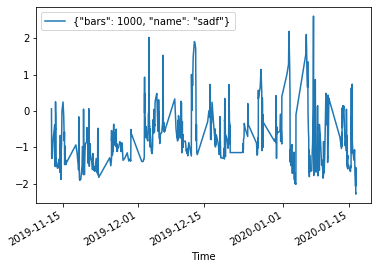

In [20]:
feats[c].plot()

In [13]:
import pandas as pd
series = pd.Series([1,2,34,4,5, 8, 9, 100, 50])
df = pd.DataFrame({'Close': series})
nplog = np.log(series).diff()






In [15]:
column = "Close"
window = 4
rolly = df[column].rolling(window)
(df[column] - rolly.mean()) / rolly.std()



0         NaN
1         NaN
2         NaN
3   -0.393518
4   -0.410702
5   -0.332907
6    1.050210
7    1.498992
8    0.189722
Name: Close, dtype: float64

In [114]:
dd = series.astype(str)

In [140]:
majority = lambda x:np.sum(x)
df = pd.DataFrame({'a' : [1,1,1,1,1,2,1,2,2,2,2]})
# df['a'] = df['a'].rolling(3).apply(majority)
df['b'] = list('aaaababbbba')

cat = pd.Categorical(df['b'])
df['b'] = pd.Series(cat.codes).rolling(3).apply(majority, raw=True)
df['b'] = df['b'].map(pd.Series(cat.categories))
print(df)


    a    b
0   1  NaN
1   1  NaN
2   1    a
3   1    a
4   1    b
5   2    b
6   1  NaN
7   2  NaN
8   2  NaN
9   2  NaN
10  2  NaN


In [126]:
pd.Series(cat.codes)

0     0
1     0
2     0
3     0
4     1
5     0
6     1
7     1
8     1
9     1
10    0
dtype: int8

In [145]:
ss

0       NaN
1       NaN
2       NaN
3       NaN
4     some_
5     ome_s
6     me_st
7     e_str
8     _stri
9     strin
10    tring
dtype: object

In [142]:
series.rolling(3).mean()

0          NaN
1          NaN
2    12.333333
3    13.333333
4    14.333333
5     5.666667
6     7.333333
7    39.000000
8    53.000000
dtype: float64